In [28]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)

# Explore Train Data

In [3]:
df_train = pd.read_csv("../data/raw/data_train.csv.gz")

In [4]:
df_category = df_category = pd.read_csv("../data/raw/category_parent.csv").dropna()

In [5]:
df_category['parent_id'] = df_category['parent_id'].replace(-1, 0)
df_category['parent_id'] = df_category['parent_id'].astype(int)
df_category['category_id'] = df_category['category_id'].astype(int)

codes, uniques = pd.factorize(list(df_category['category_id'].values))
new_root_id = len(uniques)
df_category['parent_id'] = df_category['parent_id'].apply(lambda x: list(uniques).index(x) if x != 0 else new_root_id)
df_category['category_id'] = codes

    
# Ensure all parent_id and category_id are represented as vertices
all_nodes = pd.concat([df_category['category_id'], df_category['parent_id'].dropna()]).unique()

# 1. Create a graph using igraph and add all vertices
G = ig.Graph(directed=True)
G.add_vertices([int(node) for node in all_nodes])

# 2. Add edges based on the parent-child relationship (ensure proper mapping)
edges = df_category.dropna(subset=['parent_id'])[['category_id', 'parent_id']].values

# Before adding edges, ensure the edges reference valid vertex IDs
valid_edges = [(int(edge[1]), int(edge[0])) for edge in edges if int(edge[1]) in all_nodes and int(edge[0]) in all_nodes]
G.add_edges(valid_edges)

g = G
nodes_with_multiple_parents = []

# Iterate through each vertex (node)
for v in g.vs:
    # Get the list of incoming edges to this vertex
    incoming_edges = g.incident(v, mode="IN")
    
    # Count the number of parents (incoming edges)
    if len(incoming_edges) > 1:
        nodes_with_multiple_parents.append(v.index)

# Output the result
print("Nodes with multiple parents:", nodes_with_multiple_parents)

Nodes with multiple parents: []


In [6]:
# Compute the degree of each node
degrees = G.degree()
num_leaves = sum(1 for d in degrees if d == 1)

# Output the number of leaves
print(f"Number of leaves: {num_leaves}")

invalid_nodes_by_degree = [G.vs[i]['name'] for i, d in enumerate(G.degree()) if d == 0]

print(f"Invalid nodes by degree (no connections):\n{invalid_nodes_by_degree}")

Number of leaves: 101
Invalid nodes by degree (no connections):
[]


# Simple Prediction

In [17]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [8]:
def get_ancestors(graph, node):
    # Initialize an empty list to collect ancestors
    ancestors = []
    
    # Use a queue for breadth-first traversal
    queue = [node]  # Start from the given node
    visited = set()  # To avoid cycles

    while queue:
        current = queue.pop(0)  # Dequeue the first element
        
        # Get the parents of the current node
        parents = graph.predecessors(current)
        
        for parent in parents:
            if parent not in visited:  # Check if already visited
                visited.add(parent)  # Mark the parent as visited
                ancestors.append(parent)  # Collect the parent
                queue.append(parent)  # Add parent to the queue for further exploration

    # Return the ancestors in the order from root to the direct parent
    # return [np.int64(0) if ancestor == new_root_id else uniques[ancestor] for ancestor in ancestors]
    return ancestors

In [9]:
get_ancestors(G, 77)

[76, 72, 248, 267]

In [10]:
df_train['ancestors'] = df_train['category_id'].apply(lambda x: new_root_id if x == -1 else get_ancestors(G, list(uniques).index(x))) 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train['category_id'], test_size=0.33, random_state=42)

In [12]:
FEATURE_COLS = [f"f{i}" for i in range(128)]

In [13]:
clf = svm.LinearSVC()

clf.fit(X_train[FEATURE_COLS], y_train)

LinearSVC()

In [14]:
y_pred = clf.predict(X_test[FEATURE_COLS])

In [19]:
print(f"{accuracy_score(y_test, y_pred):.2%} of global accuracy")

66.31% of global accuracy


In [20]:
cm = confusion_matrix(y_test, y_pred)

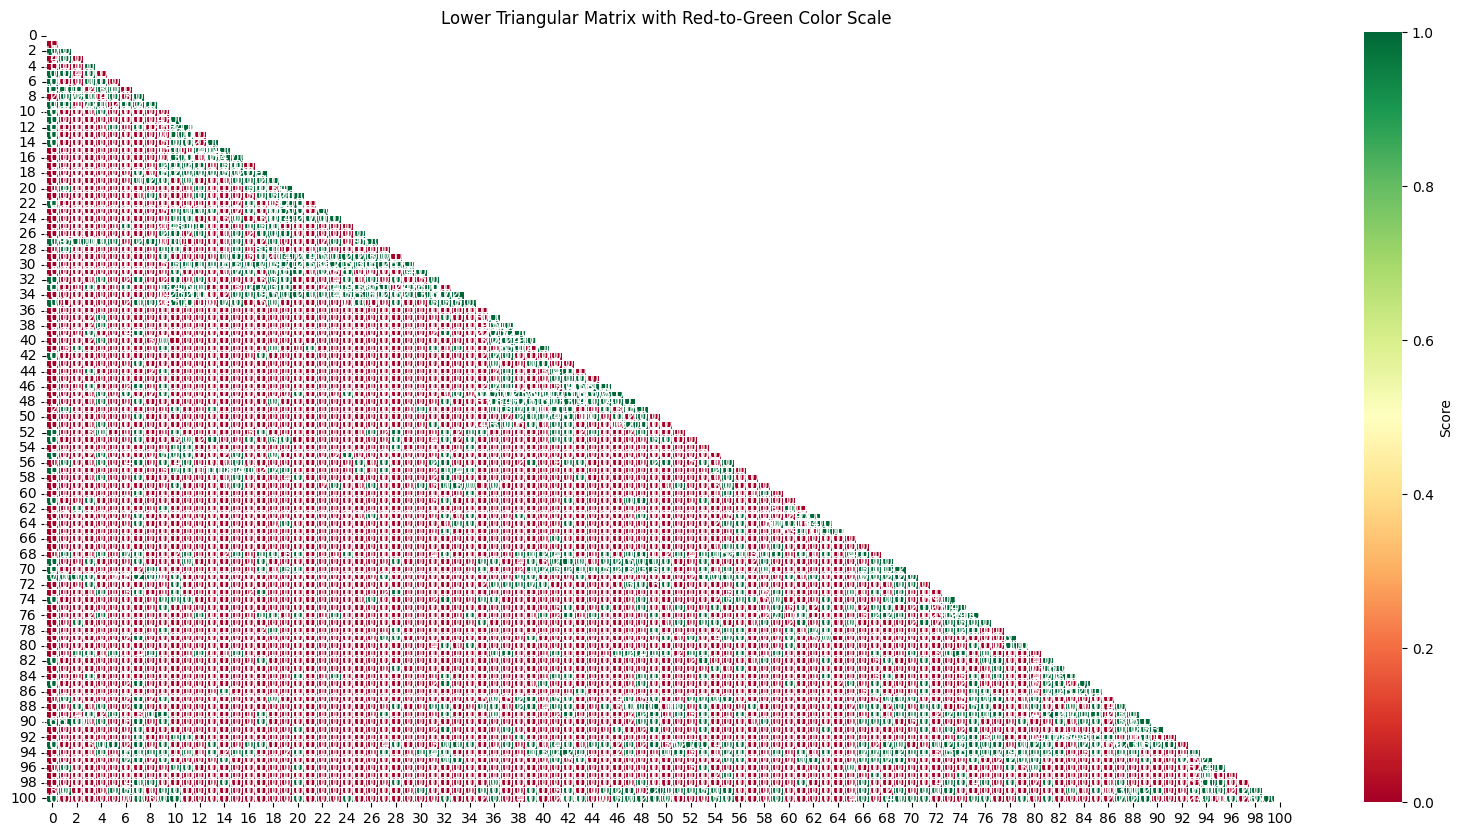

In [30]:
# Mask the upper triangle
mask = np.triu(np.ones_like(cm, dtype=bool))

# Create a custom color palette from red to green
cmap = sns.color_palette("RdYlGn", as_cmap=True)

# Plotting the lower triangular matrix with a color scale from red to green
sns.heatmap(cm, mask=mask, cmap=cmap, annot=True, fmt=".2f", 
            linewidths=0.5, cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
plt.title('Lower Triangular Matrix with Red-to-Green Color Scale')
plt.show()

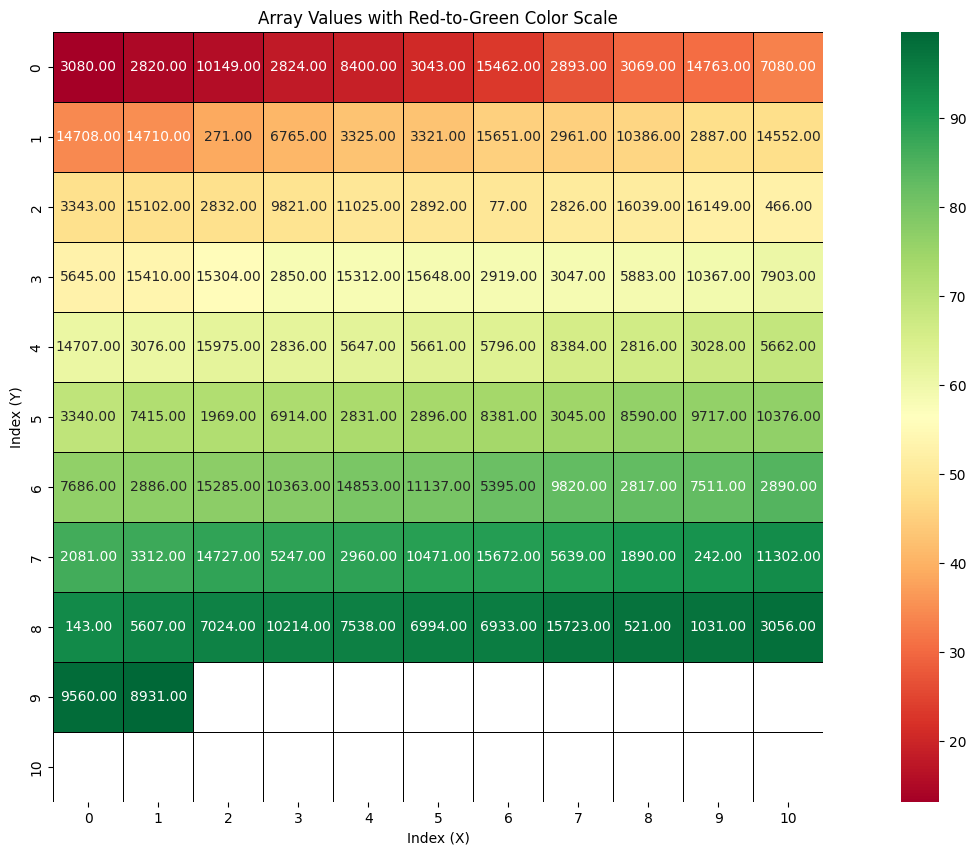

In [82]:
acc_by_class = (cm.diagonal() * 100 / X_test.category_id.value_counts().sort_index().values).round(2)
sorted_class_name = X_test.category_id.value_counts().sort_index().index[np.argsort(acc_by_class)]
acc_by_class = np.sort(acc_by_class)

side_length = int(np.ceil(np.sqrt(len(acc_by_class))))
square_data = np.full((side_length, side_length), np.nan)
square_data.flat[:len(acc_by_class)] = acc_by_class  # Fill the grid with the data

annotations = np.reshape(
    (list(sorted_class_name) + [None]*((len(square_data)**2) - len(sorted_class_name))),
    (len(square_data),
    len(square_data))
)

# Plot the heatmap
cmap = sns.color_palette("RdYlGn", as_cmap=True)  # Red to green color scale
sns.heatmap(
    square_data,
    annot=annotations,
    fmt=".2f",
    cmap=cmap,
    cbar=True, 
    linewidths=0.5,
    linecolor='black',
    square=True,
    vmin=min(acc_by_class),
    vmax=max(acc_by_class)
)

# Add labels
plt.title('Array Values with Red-to-Green Color Scale')
plt.xlabel('Index (X)')
plt.ylabel('Index (Y)')
plt.show()

# Recurcive prediction

In this section, we will train a model to classify articles in a step-by-step, hierarchical manner. At the root level, predictions will be made for all articles. For subsequent levels, however, predictions will only proceed if the probability score exceeds a predefined threshold.

This approach aims to reduce the number of misclassifications and can lead to the creation of a back-office system to manually handle articles that are more challenging to classify accurately.

In [83]:
CONFIDENCE_THRESHOLD = 0.75

queue = [new_root_id]

while len(queue):

    current_node = queue.pop()
    successors = G.successors(current_node)
    queue += successors
    
    if len(successors) == 0:
        print(f"Node {current_node} is a leaf")
        continue

    print(f"Processing node {current_node}")
    
    train_mask = X_train["ancestors"].apply(lambda x: len(set(x).intersection(set(successors))) > 0)
    sub_X_train = X_train[train_mask]
    sub_y_train = sub_X_train["ancestors"].apply(lambda x: list(set(x).intersection(set(successors)))[0])

    if len(sub_X_train) == 0:
        print(f"No training data for {current_node}")
        continue
        
    if current_node != new_root_id:
        test_mask = X_test["predictions"].apply(lambda x: current_node in set(x))
        sub_X_test = X_test[test_mask]
    else:
        sub_X_test = X_test
        sub_X_test["predictions"] = [[] for _ in range(len(sub_X_test))]

    if len(sub_X_test) == 0:
        print(f"No data in test for {current_node}")
        # y_pred = [successors[0]] * len(sub_X_test)
        continue

    if len(sub_y_train.unique()) == 1:
        print(f"Only one child for {current_node}")
        y_pred = zip(
            [successors[0]] * len(sub_X_test),
            [1.0] * len(sub_X_test)
        )
    else:
        print(f"Training node {current_node}")
        if current_node == new_root_id:
            clf = svm.LinearSVC()
            clf.fit(sub_X_train[FEATURE_COLS], sub_y_train)
            y_pred = zip(
                clf.predict(sub_X_test[FEATURE_COLS]),
                [1.0] * len(sub_X_test)
            )
        else:
            clf = svm.SVC(probability=True)
            clf.fit(sub_X_train[FEATURE_COLS], sub_y_train)
            y_pred = (
                [clf.classes_[pred.argmax()], pred.max()]
                for pred in clf.predict_proba(sub_X_test[FEATURE_COLS])
            )

    for i, row in sub_X_test.iterrows():
        pred, proba = next(y_pred)
        if proba >= CONFIDENCE_THRESHOLD:
            sub_X_test.at[i, "predictions"] += [pred]
    X_test.loc[sub_X_test.index, "predictions"] = sub_X_test["predictions"]


# Complete predictions
for i, row in X_test.iterrows():
    last_prediction = row["predictions"][-1]
    while len(G.successors(last_prediction)) == 1:
        row["predictions"].append(G.successors(last_prediction)[0])
        last_prediction = G.successors(last_prediction)[0]

# Check if predictions are leaves
X_test["leaf_predicted"] = X_test["predictions"].apply(lambda x: len(G.successors(x[-1])) == 0)

Processing node 267
Training node 267
Processing node 266
Training node 266
Processing node 242
Only one child for 242
Processing node 243
No training data for 243
Node 244 is a leaf
Processing node 236
Only one child for 236
Processing node 237
No training data for 237
Node 238 is a leaf
Processing node 265
Training node 265
Processing node 239
Only one child for 239
Processing node 240
No training data for 240
Node 241 is a leaf
Processing node 233
Only one child for 233
Processing node 234
No training data for 234
Node 235 is a leaf
Processing node 230
Only one child for 230
Processing node 231
No training data for 231
Node 232 is a leaf
Processing node 225
Training node 225
Processing node 228
No training data for 228
Node 229 is a leaf
Processing node 226
No training data for 226
Node 227 is a leaf
Processing node 264
Training node 264
Processing node 219
No data in test for 219
Processing node 220
No training data for 220
Node 221 is a leaf
Processing node 211
Only one child for 

In [86]:
print(f"{(X_test['leaf_predicted'].sum() / len(X_test)):.2%} articles in a leaf node")

39.00% articles in a leaf node


In [87]:
y_pred = X_test["predictions"].apply(lambda x: uniques[x[-1]])

In [89]:
print(f"{accuracy_score(y_test[X_test['leaf_predicted']], y_pred[X_test['leaf_predicted']]):.2%} of global accuracy")

68.28% of global accuracy


Only 39% of the articles reach a leaf node, and the overall accuracy shows only a slight improvement.